In [1]:
import numpy as np
import math
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
import csv
import pandas as pd

Using TensorFlow backend.


In [19]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def pre_process(path):
    label=[]
    data=[]
    with open(path, 'r') as csvFile:
        reader = csv.reader(csvFile)
        next(reader)
        for row in reader:
            label.append(row[0])
            img=np.array(row[1:],dtype='float')/255.0
            img.resize(28,28)
            data.append(img)
    data=np.array(data)
    label=np.array(label,dtype='int')
    return data, label   

def pre_process_test(path):
    data=[]
    with open(path, 'r') as csvFile:
        reader = csv.reader(csvFile)
        next(reader)
        for row in reader:
            img=np.array(row[0:],dtype='float')/255.0
            img.resize(28,28)
            data.append(img)
    data=np.array(data)
    return data   

In [3]:
def save_file(path,y_predict):
    dict={'ImageId':np.arange(y_predict.shape[0])+1, 'Label':y_predict}
    df=pd.DataFrame(dict)
    df.to_csv('sample_submission.csv',index=False,header=True )
    return 
 

In [38]:
data_train, label_train=pre_process('train.csv')
data_test=pre_process_test('test.csv')

In [39]:
x_train_img, x_val_img, label_train, label_val = train_test_split(data_train, label_train, test_size=0.1, random_state=42)

image train num:  42000
image test num:  28000
label:  0


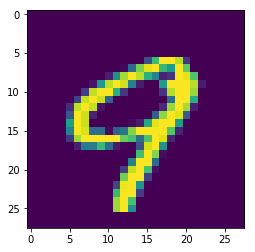

In [40]:
print('image train num: ',len(data_train))
print('image test num: ',len(data_test))
print('label: ',label_train[100])
plt.imshow(data_train[100])
plt.show()

In [41]:
num_classes=10
temp=[]
y_train = (keras.utils.to_categorical(label_train, num_classes)).T
y_val = (keras.utils.to_categorical(label_val, num_classes)).T
for i in range(0,len(x_train_img)):
    temp.append(np.ndarray.flatten(x_train_img[i]))
x_train=np.array(temp).T
temp.clear()
for i in range(0,len(data_test)):
    temp.append(np.ndarray.flatten(data_test[i]))
x_test=np.array(temp).T
temp.clear()
for i in range(0,len(x_val_img)):
    temp.append(np.ndarray.flatten(x_val_img[i]))
x_val=np.array(temp).T

In [42]:
print('x_train:',x_train.shape)
print('y_train:',y_train.shape)

print('x_val:',x_val.shape)
print('y_val:',y_val.shape)

print('x_test:',x_test.shape)

x_train: (784, 37800)
y_train: (10, 37800)
x_val: (784, 4200)
y_val: (10, 4200)
x_test: (784, 28000)


In [43]:
def sigmoid(x):# Hàm sigmoid
    return 1/(1+np.exp(-x))

def sigmoid_grad(a):# Đạp hàm sigmoid
    return a*(1-a)

def relu(x):# hàm relu
    x[x<0] = 0
    return x

def relu_grad(a):# Đạo hàm hàm relu
    a[a>0] = 1
    return a

def softmax(x):# Hàm softmax
    output = np.exp(x-x.max())
    output = output/output.sum(axis=0)
    return output

In [44]:
class Layer():
    def __init__(self,input_shape,num_node,activation='relu'):
        self.input_shape=input_shape #(feature,num)
        self.num_node=num_node #number node
        self.activation=activation
        self.w=0.01*np.random.rand(input_shape[0],self.num_node) #(pre_layer num_node,layer_numnode)
        self.b=np.zeros((num_node,1))
    
    # Lan truyền tiến
    def forward(self,pre_a):
        z=np.dot(self.w.T,pre_a)+self.b #()
        
        if self.activation=='relu':
            a=relu(z)
            
        if self.activation=='sigmoid':
            a=sigmoid(z)
            
        if self.activation=='softmax':
            a=softmax(z)      
        return a
    
    def backward(self,pre_a, pre_theta, pre_w):
        
        a=self.forward(pre_a)
        
        if self.activation == 'sigmoid':
            da_dz = sigmoid_grad(a)
            
        if self.activation == 'relu':
            da_dz = relu_grad(a)
        
        theta=np.dot(pre_w,pre_theta)*da_dz
        
        d_w=np.dot(pre_a,theta.T)
        
        d_b = np.sum(theta, axis = 1, keepdims = True)
        
        return d_w,d_b,theta
    
    

In [45]:
class Neural_Network(object):
    def __init__(self):
        self.layers = []
        
    # Thêm layer vào Mô hình NN    
    def add_layer(self,input_shape,num_node,activation):
        self.layers.append(Layer(input_shape,num_node,activation))
    
    # Tính đỗ lỗi mô hình
    def compute_loss(self,y, y_hat):
        return -np.sum(y*np.log(y_hat))/y.shape[1]
      
      
    # LAn truyền tiến trên NN
    def forward(self,X):
        A = [X]
        # output của mỗi layer được append vào A
        for layer in self.layers:
            A.append(layer.forward(A[-1]))
        return A
    #Lan truyền ngược trên NN
    
    def backward(self,y,A):
        # tính toán tham số của oupput layer
        theta_L = (A[-1] - y)/y.shape[1]
        dW_L = np.dot(A[-2],theta_L.T)
        
        dB_L = np.sum(theta_L, axis = 1, keepdims = True)
        
        dW_list =[dW_L]
        
        dB_list =[dB_L]

        prev_theta = theta_L
        
        # Thực hiện lan truyền ngược
        for i in range(0,len(self.layers)-1)[::-1]:
            prev_a = A[i]
            prev_w =self.layers[i + 1].w
            dw,db,prev_theta = self.layers[i].backward(prev_a,prev_theta,prev_w)
            dW_list.append(dw)
            dB_list.append(db)
        return dW_list[::-1],dB_list[::-1]

    # CẬP nhật trong số
    def update_w(self, dW_list,dB_list, learning_rate):
        for i in range(len(self.layers)):
            self.layers[i].w = self.layers[i].w - learning_rate * dW_list[i]
            self.layers[i].b = self.layers[i].b - learning_rate * dB_list[i]
            
    
    def random_mini_batches(self,X_data,y_data,mini_batch_size):
        
        X=X_data.T
        y=y_data.T
      
        m = X.shape[0]
        
        mini_batches = []
        permutation = list(np.random.permutation(m))
        shuffled_X = X[permutation,:]
        shuffled_Y = y[permutation,:]

        # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
        num_complete_minibatches = math.floor(
            m / mini_batch_size)  # number of mini batches of size mini_batch_size in your partitionning
        for k in range(0, num_complete_minibatches):
            mini_batch_X = shuffled_X[ k * mini_batch_size: (k + 1) * mini_batch_size,:]
            mini_batch_Y = shuffled_Y[ k * mini_batch_size: (k + 1) * mini_batch_size,:]
            mini_batch = (mini_batch_X.T, mini_batch_Y.T)
            mini_batches.append(mini_batch)

        # Handling the end case (last mini-batch < mini_batch_size)
        if m % mini_batch_size != 0:
            mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size: m,:]
            mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size: m,:]
            mini_batch = (mini_batch_X.T, mini_batch_Y.T)
            mini_batches.append(mini_batch)

        return mini_batches

    
        

    def fit(self,X,y,label_train,x_val,label_val,learning_rate=0.05,epochs=5, batch_size=32):
        all_loss = []
        
        for e in range(epochs):
            mini_batches = self.random_mini_batches(X,y,batch_size)
            for mini_batch_X, mini_batch_Y in mini_batches:   
                A = self.forward(mini_batch_X)
                y_hat = A[-1]
                loss = self.compute_loss(mini_batch_Y, y_hat)
                dW_list,dB_list = self.backward(mini_batch_Y, A)
                self.update_w(dW_list,dB_list, learning_rate)              
            
            B=self.forward(x_val)
            predicted_class = np.argmax(B[-1], axis=0)
            C=self.forward(X)
            predicted_class_train = np.argmax(C[-1], axis=0)
            
            print("Epoch %d: loss is %.5f" % (e + 1, loss),',train acc: %.2f %%' % (100*np.mean(predicted_class_train == label_train))
                  ,',val acc: %.2f %%' % (100*np.mean(predicted_class == label_val)))
                
        return all_loss
              
          
      
    def predict(self,X):
        A=self.forward(X)
        predicted_class = np.argmax(A[-1], axis=0)
        #print('training accuracy: %.2f %%' % (100*np.mean(predicted_class == y)))
        
        return predicted_class
      
      
        
      
      
   

In [46]:
NN=Neural_Network()

In [47]:
NN.add_layer(input_shape=x_test.shape,num_node=1000,activation='relu')
NN.add_layer(input_shape=(1000,x_test.shape[1]),num_node=10,activation='softmax')
#NN.add_layer(input_shape=(128,x_test.shape[1]),num_node=32,activation='relu')
#NN.add_layer(input_shape=(32,x_test.shape[1]),num_node=10,activation='softmax')


In [48]:
NN.fit(x_train,y_train,label_train,x_val,label_val,learning_rate=0.1,epochs=32, batch_size=32)

Epoch 1: loss is 0.06288 ,train acc: 92.05 % ,val acc: 91.60 %
Epoch 2: loss is 0.62089 ,train acc: 91.96 % ,val acc: 90.69 %
Epoch 3: loss is 0.02709 ,train acc: 96.72 % ,val acc: 95.83 %
Epoch 4: loss is 0.55114 ,train acc: 91.66 % ,val acc: 90.14 %
Epoch 5: loss is 0.01448 ,train acc: 97.89 % ,val acc: 96.62 %
Epoch 6: loss is 0.13216 ,train acc: 98.41 % ,val acc: 96.86 %
Epoch 7: loss is 0.00106 ,train acc: 98.70 % ,val acc: 97.02 %
Epoch 8: loss is 0.05576 ,train acc: 98.66 % ,val acc: 97.02 %
Epoch 9: loss is 0.00288 ,train acc: 99.07 % ,val acc: 97.29 %
Epoch 10: loss is 0.00444 ,train acc: 99.32 % ,val acc: 97.50 %
Epoch 11: loss is 0.00108 ,train acc: 99.43 % ,val acc: 97.62 %
Epoch 12: loss is 0.00561 ,train acc: 99.55 % ,val acc: 97.83 %
Epoch 13: loss is 0.01445 ,train acc: 99.63 % ,val acc: 97.57 %
Epoch 14: loss is 0.01134 ,train acc: 99.79 % ,val acc: 97.86 %
Epoch 15: loss is 0.00756 ,train acc: 99.83 % ,val acc: 97.50 %
Epoch 16: loss is 0.00086 ,train acc: 99.86 % ,va

[]

In [49]:
kq=NN.predict(x_test)

In [50]:
save_file('sample_submission.csv',np.array(kq))